In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  %cd /content/drive/MyDrive/M5_Project/Week4
  !ls

Mounted at /content/drive
/content/drive/MyDrive/M5_Project/Week4
datasets.py	 losses.py   networks.py  taskb.ipynb
image_loader.py  metrics.py  __pycache__  trainer.py


In [2]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
# Not used anymore
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

## Calculate mean ans std for MIT split
# TRANSFORM_IMG = transforms.Compose([
#     transforms.ToTensor(),
#     ])

# TRAIN_DATA_PATH = "../MIT_split/train/"
# train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
# cuda = torch.cuda.is_available()
# kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
# train_loader = DataLoader(train_data, batch_size=128, shuffle=True, **kwargs)

# mean, std = get_mean_and_std(train_loader)

# Prepare Dataset

In [ ]:
TRAIN_DATA_PATH = "../MIT_split/train/"
TEST_DATA_PATH = "../MIT_split/test/"

batch_size = 64

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 8

In [ ]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 128, 128])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mit_classes = ['coast', 'forest', 'highway', 'inside_city', 'mountain',
                         'Opencountry', 'street', 'tallbuilding']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(8):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mit_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline

In [ ]:
# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet_v2
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet_v2(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
    print('Cuda!!!')
loss_fn = torch.nn.NLLLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.96)
n_epochs = 20
log_interval = 100

Cuda!!!


In [ ]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/1881 (0%)]	Loss: 2.174892	Accuracy: 20.3125
Epoch: 1/20. Train set: Average loss: 2.4907	Accuracy: 15.629984051036683
Epoch: 1/20. Validation set: Average loss: 2.0691	Accuracy: 16.356877323420075
Train: [0/1881 (0%)]	Loss: 2.030827	Accuracy: 17.1875
Epoch: 2/20. Train set: Average loss: 1.9811	Accuracy: 20.680489101541735
Epoch: 2/20. Validation set: Average loss: 1.9049	Accuracy: 24.907063197026023
Train: [0/1881 (0%)]	Loss: 1.780739	Accuracy: 32.8125
Epoch: 3/20. Train set: Average loss: 1.7279	Accuracy: 34.82190324295588
Epoch: 3/20. Validation set: Average loss: 1.6311	Accuracy: 35.811648079306075
Train: [0/1881 (0%)]	Loss: 1.680759	Accuracy: 31.25
Epoch: 4/20. Train set: Average loss: 1.5616	Accuracy: 37.79904306220096
Epoch: 4/20. Validation set: Average loss: 1.5606	Accuracy: 36.926889714993806
Train: [0/1881 (0%)]	Loss: 1.491982	Accuracy: 42.1875
Epoch: 5/20. Train set: Average loss: 1.4406	Accuracy: 42.15842636895268
Epoch: 5/20. Validation set: Average loss: 1.5975

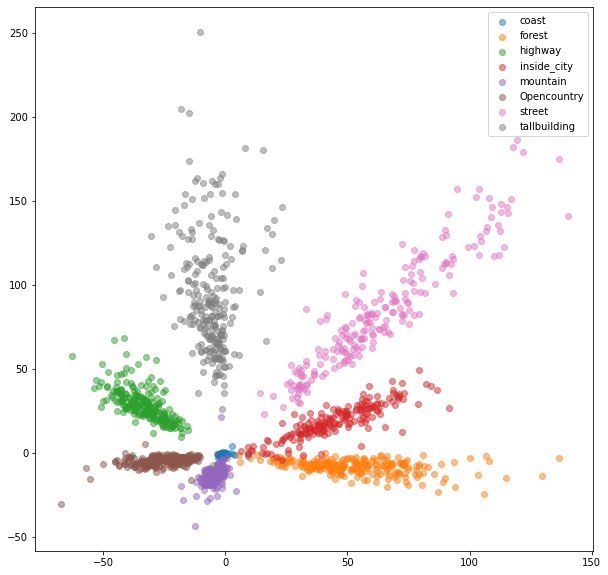

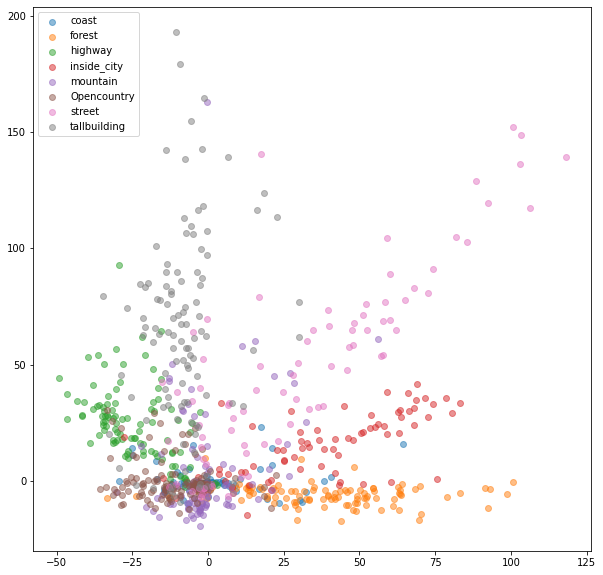

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# SiameseNet

In [3]:
from PIL import Image
import pickle
import torch
import glob
import random
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets
class MITSplitDataset_v2(Dataset):
    def __init__(self,train_path,test_path, transform, train):
        # Transforms
        self.transform=transform
        self.train=train
        self.to_tensor = transforms.ToTensor()

        # Read the csv file
        if self.train:
            self.train_data_info = pd.read_csv(train_path,header=None)
            self.train_data =[] 
            
            print("printing train data length MIT Split")
            # print(len(self.train_data_info.index))

            for (i,j) in enumerate(np.asarray(self.train_data_info.iloc[:, 1])):
                try :
                    self.train_data.append(self.to_tensor(Image.open(j))) 
                except : 
                    print('ERROR LOADING:' + j)
            
            self.train_data = torch.stack(self.train_data)
            self.train_labels = np.asarray(self.train_data_info.iloc[:, 2])
            self.train_labels = torch.from_numpy(self.train_labels)

            self.train_data_len = len(self.train_data_info.index)

        else :
            self.test_data_info = pd.read_csv(test_path,header=None)
            self.test_data =[] 
            for (i,j) in enumerate(np.asarray(self.test_data_info.iloc[:, 1])):
                try : 
                    self.test_data.append(self.to_tensor(Image.open(j))) 
                except : 
                    print('ERROR LOADING:' + j) 

            self.test_data = torch.stack(self.test_data)
            self.test_labels = np.asarray(self.test_data_info.iloc[:, 2])
            self.test_labels = torch.from_numpy(self.test_labels)
            
            self.test_data_len = len(self.test_data_info.index)
            

    def __getitem__(self, index):
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # if self.transform:
        #     img = self.transform(img)

        return (img,target)

    def __len__(self):
        if self.train :
            return self.train_data_len
        else :
            return self.test_data_len

In [7]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
from datasets import SiameseMNIST

cuda = torch.cuda.is_available()

TRAIN_DATA_PATH = "../MIT_split/train_data.csv"
TEST_DATA_PATH = "../MIT_split/test_data.csv"

# from image_loader import MITSplitDataset_v2
from datasets import SiameseDataset

batch_size = 64

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

TRANSFORM_IMG_TEST = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

train_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG, train= True)
test_data = MITSplitDataset_v2(TRAIN_DATA_PATH, TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST, train= False)

siamese_train_dataset = SiameseMNIST(train_data) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_data)

batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.9, last_epoch=-1)
n_epochs = 20
log_interval = 500

printing train data length MIT Split


In [5]:
for X, y in siamese_train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

TypeError: ignored

In [ ]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


## Balanced Batch Sampler

In [ ]:
# Set up data loaders
from datasets import BalancedBatchSampler
import numpy as np

# train_labels = np.array(train_data.targets, dtype=np.float32)
# test_labels = np.array(test_data.targets, dtype=np.float32)

# Step 1
train_batchSampler = BalancedBatchSampler(train_data.targets, n_classes=n_classes, n_samples=n_classes)
test_batchSampler = BalancedBatchSampler(test_data.targets, n_classes=n_classes, n_samples=n_classes)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = DataLoader(train_data, batch_sampler=train_batchSampler, **kwargs)
siamese_test_loader = DataLoader(test_data, batch_sampler=test_batchSampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma=0.96)
# scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 30
log_interval = 500

In [ ]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


TypeError: ignored

In [ ]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)